# Исследование работы модели

In [18]:
import xmltodict, json, os, re, sys
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import statistics

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [19]:
os.chdir('/home/vvs/Documents/Telegram clustering')

In [22]:
f_in = open('./output/en/glove_en_1ep.txt')
len_counter = []
counter = -1
counting = False
for line in f_in:
    if line[:2] == 'pr':
        counting = True
    elif line[:2] == 'f1':
        counting = False
        len_counter.append(counter)
        counter = -1
    if counting:
        counter +=1


## Визуальный анализ распеделения тестовой выорки по количеству фраз в диалоге

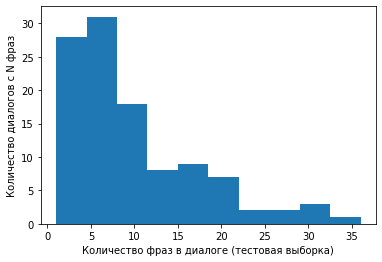

In [23]:
x, bins, p=plt.hist(len_counter)  
plt.ylabel('Количество диалогов с N фраз')
plt.xlabel('Количество фраз в диалоге (тестовая выборка)') 
plt.show()

In [24]:
statistics.mean(len_counter)

9.587155963302752

Распределение похоже на логнормальное, максимальное количество фраз в диалоге - 35 , математическое ожидание - около 10 фраз.

## Исследование зависимости F1 меры от длинны диалога

In [25]:


def f_1_micro(txtfile, dummy = False):
    """
    возвращает micro-avg F1, сортированый список с указанием длинны диалога в фразах,
    список F1, сортированный по длинне диалога в фразах. 
    """
    txtfile = open(txtfile)
    gt_x = []
    gt_y = []
    pr_x = []
    pr_y = []
    diag_gt_x = [-1]
    diag_gt_y = [-1]
    diag_pr_x = [-1]
    diag_pr_y = [-1]

    gt = False
    pr = False

    digit = re.compile(r"[\d]+")

    for line in txtfile:
        if line[:2] == 'gr':
            gt = True
        if line[:2] == 'pr':
            gt = False
            gt_x.append(diag_gt_x[1:])
            gt_y.append(diag_gt_y[1:])
            diag_gt_x = [-1]
            diag_gt_y = [-1]
            pr = True
        if line[:2] == 'f1':
            pr = False
            pr_x.append(diag_pr_x[1:])
            pr_y.append(diag_pr_y[1:])
            diag_pr_x = [-1]
            diag_pr_y = [-1]
        if gt:
            digits = digit.findall(line)
            if len(digits) != 0:
                digits = [int(digit) for  digit in digits]
                if not (digits[1] in diag_gt_y):
                    if len(diag_gt_y)>1 and digits[1] -1 != diag_gt_y[-1]:
                        diag_gt_x.append(digits[1]-2)
                        diag_gt_y.append(digits[1]-1)
                    diag_gt_x.append(digits[0])
                    diag_gt_y.append(digits[1])
        if pr:
            digits = digit.findall(line)
            digits = [int(digit) for  digit in digits]
            if len(digits) != 0:
                if dummy:
                    diag_pr_x.append(digits[1]-1)
                else:
                    diag_pr_x.append(digits[0])
                diag_pr_y.append(digits[1]) 
    len_dialog = []
    f1_scores = []
    for gt,  pr in zip(gt_x, pr_x):
        len_dialog.append(len(gt))
        f1_scores.append(f1_score(gt,  pr, average='micro'))
    flat_gt = [item for sublist in gt_x for item in sublist]
    flat_pr = [item for sublist in pr_x for item in sublist]

    return f1_score(flat_gt,  flat_pr, average='micro'), len_dialog, f1_scores
    
    

In [26]:
f_in_e_gl = './output/en/glove_en_30ep.txt'
f_in_r_gl = './output/glove_ru/glove_ru_40ep.txt'
f_in_r_tf = './output/ddp_p3/ddp_3_30ep.txt'

en_f1 = pd.DataFrame(columns = ['len','f1_en_glove', 'f1_ru_glove', 'f1_ru_fasttext','f1_dummy'])
f1_micro_en_glove, en_f1['len'], en_f1['f1_en_glove']= f_1_micro(f_in_e_gl)
f1_micro_ru_glove, _ , en_f1['f1_ru_glove']= f_1_micro(f_in_r_gl)
f1_micro_ru_fasttext, _ , en_f1['f1_ru_fasttext']= f_1_micro(f_in_r_tf)
f1_micro_dummy, _ , en_f1['f1_dummy']= f_1_micro(f_in_r_tf, dummy = True)


In [27]:

def poly_interpolation(x_arr, y_arr, poly_n = 2, lw = 4):
    x_plot = np.linspace(x_arr.min(), x_arr.max(), 100)
    x = x_arr
    X = x_arr[:, np.newaxis]
    X_plot = x_plot[:, np.newaxis]
    model = make_pipeline(PolynomialFeatures(poly_n), Ridge())
    model.fit(X, y_arr)
    y_plot = model.predict(X_plot)
    y_plot = [y if y < 1 else 1 for y in y_plot]
    return X_plot, y_plot 
    

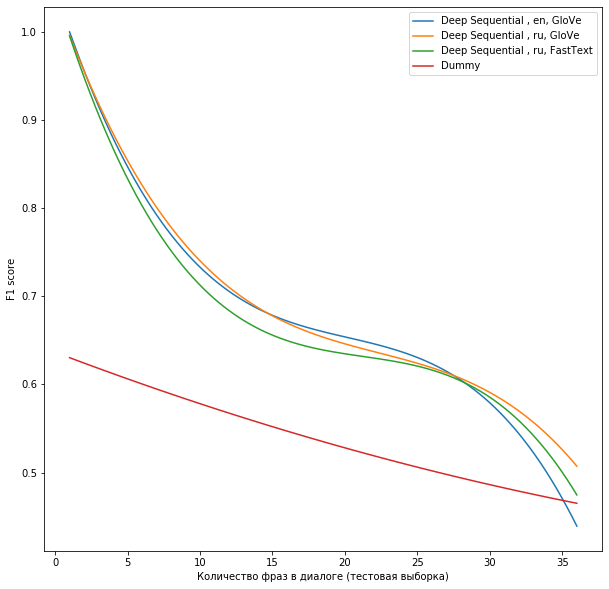

In [36]:
f1_by_len_en_gl = en_f1.groupby(['len'])['f1_en_glove'].mean().reset_index()
f1_by_len_ru_gl = en_f1.groupby(['len'])['f1_ru_glove'].mean().reset_index()
f1_by_len_ru_ft = en_f1.groupby(['len'])['f1_ru_fasttext'].mean().reset_index()
f1_by_len_dum = en_f1.groupby(['len'])['f1_dummy'].mean().reset_index()


x_en_gl_poly, y_en_gl_poly = poly_interpolation(f1_by_len_en_gl['len'], 
                                                f1_by_len_en_gl['f1_en_glove'], 
                                                poly_n =3, lw =6)
x_ru_gl_poly, y_ru_gl_poly = poly_interpolation(f1_by_len_ru_gl['len'], 
                                                f1_by_len_ru_gl['f1_ru_glove'], 
                                                poly_n =3, lw =6)
x_ru_ft_poly, y_ru_ft_poly = poly_interpolation(f1_by_len_ru_ft['len'], 
                                                f1_by_len_ru_ft['f1_ru_fasttext'], 
                                                poly_n =3, lw =6)
x_dum_poly, y_dum_poly = poly_interpolation(f1_by_len_dum['len'],
                                            f1_by_len_dum['f1_dummy'], 
                                                poly_n =2, lw =6)


plt.figure(figsize=(10,10))
plt.plot(
#          f1_by_len_en_gl['len'], f1_by_len_en_gl['f1_en_glove'], 'o', 
#          f1_by_len_ru_gl['len'], f1_by_len_ru_gl['f1_ru_glove'], 'ro', 
#          f1_by_len_ru_ft['len'], f1_by_len_ru_ft['f1_ru_fasttext'], 'bo',
#          f1_by_len_dum['len'], f1_by_len_dum['f1_dummy'], 'yo',
         x_en_gl_poly, y_en_gl_poly, '-',
         x_ru_gl_poly, y_ru_gl_poly, '-',
         x_ru_ft_poly, y_ru_ft_poly, '-',
         x_dum_poly, y_dum_poly , '-'
        )
plt.legend([
#     'f1_en_glove',
#     'f1_ru_glove',
#     'f1_ru_fasttext',
#     'f1_dummy', 
    'Deep Sequential , en, GloVe', 
    'Deep Sequential , ru, GloVe',
    'Deep Sequential , ru, FastText',
    'Dummy'
], loc='best')
plt.ylabel('F1 score')
plt.xlabel('Количество фраз в диалоге (тестовая выборка)') 
plt.show()



In [29]:
print('Значения micro-avg F1 для моделей с различными векторными представлениями')
print(f'micro-avg F1 english GloVe: {round(f1_micro_en_glove,3)}')
print(f'micro-avg F1 russian GloVe: {round(f1_micro_ru_glove,3)}')
print(f'micro-avg F1 russian Fasttext: {round(f1_micro_ru_fasttext,3)}')
print(f'micro-avg F1 dummy: {round(f1_micro_dummy,3)}')


Значения micro-avg F1 для моделей с различными векторными представлениями
micro-avg F1 english GloVe: 0.697
micro-avg F1 russian GloVe: 0.704
micro-avg F1 russian Fasttext: 0.69
micro-avg F1 dummy: 0.54


In [30]:


def f1_dataframe(dir_path):
    ep_no = re.compile(r"\d+(?=ep.txt)")
    arr_files = os.listdir(dir_path)

    rows_list = []

    for out_file in arr_files:
        dict1 = {}
        dest_f = dir_path+out_file
        ep_n = int(ep_no.findall(dest_f)[0]) 
        dict1.update({'epoch' : ep_n}) 
        f1_ep, _, _ = f_1_micro(dest_f)
        dict1.update({'f1' : f1_ep}) 
        rows_list.append(dict1)

    df = pd.DataFrame(rows_list)
    df.sort_values(by=['epoch'], inplace = True)
    return df


In [34]:
fasttext_dir_name = './output/ddp_p3/'
fasttext_df = f1_dataframe(fasttext_dir_name)
glove_dir_name = './output/glove_ru/'
glove_df = f1_dataframe(glove_dir_name)
glove_dir_name_en = './output/en/'
glove_df_en = f1_dataframe(glove_dir_name_en)

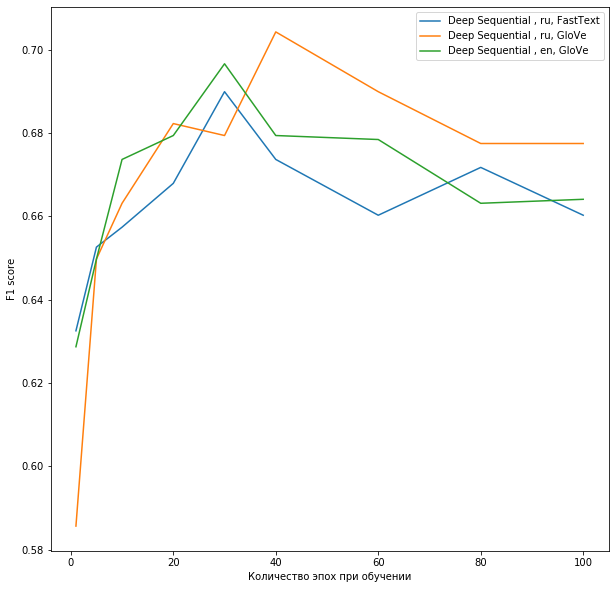

In [35]:
plt.figure(figsize=(10,10))
plt.plot(
         fasttext_df['epoch'], fasttext_df['f1'], '-', 
         glove_df['epoch'], glove_df['f1'], '-', 
         glove_df_en['epoch'], glove_df_en['f1'], '-', 
        )
plt.legend([
    'Deep Sequential , ru, FastText', 
    'Deep Sequential , ru, GloVe',
    'Deep Sequential , en, GloVe',
], loc='best')
plt.ylabel('F1 score')
plt.xlabel('Количество эпох при обучении') 
plt.show()